In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Import the necessary libraries.
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed
from pyod.models.pca import PCA as PCA_PYOD
from pyod.models.kpca import KPCA as KPCA_PYOD
from scipy.io import loadmat
import os
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.metrics import f1_score


### Iris dataset

In [2]:
data = []
target = []
dimensionality = []
dataset = []

iris = load_iris()
name = 'iris'

In [3]:
var = name+"_data"
df = iris

var = pd.DataFrame(data=df, columns=df.feature_names)
var.columns = ['feature{}'.format(i) for i in range(0,var.shape[1])]

data = pd.DataFrame(df.data)
target = pd.DataFrame(df.target)
dataset = pd.DataFrame(df.data).assign(target=df.target)
print (dataset.shape,pd.DataFrame(df.target).nunique().tolist()[-1:])

(150, 5) [3]


In [4]:
dataset.head()

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
Counter(dataset['target'])

Counter({0: 50, 1: 50, 2: 50})

In [6]:
dataset_0 = dataset.copy()
dataset_0['target']= (dataset_0['target']==1)
dataset_0 = dataset_0.drop(dataset_0[dataset_0['target'] == False].sample(frac=0.80).index)
Counter(dataset_0['target'])

Counter({False: 20, True: 50})

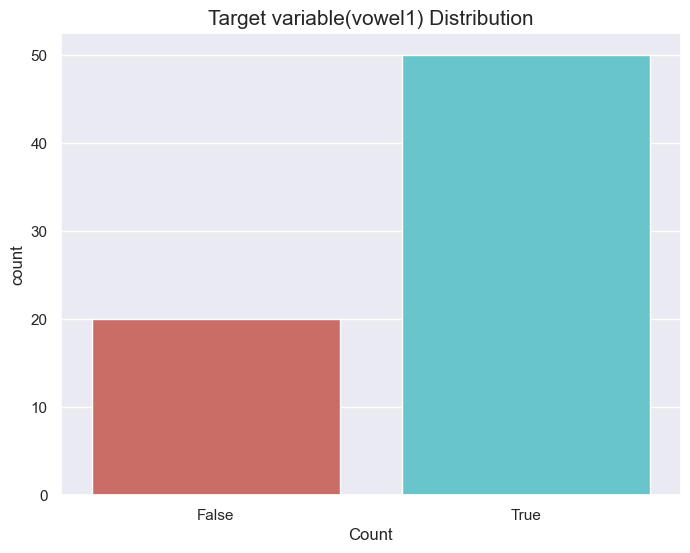

In [7]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="target",data= dataset_0, palette="hls")                  
g1.set_title("Target variable(vowel1) Distribution", fontsize=15)
g1.set_xlabel("Vowel1")
g1.set_xlabel("Count")
plt.show()

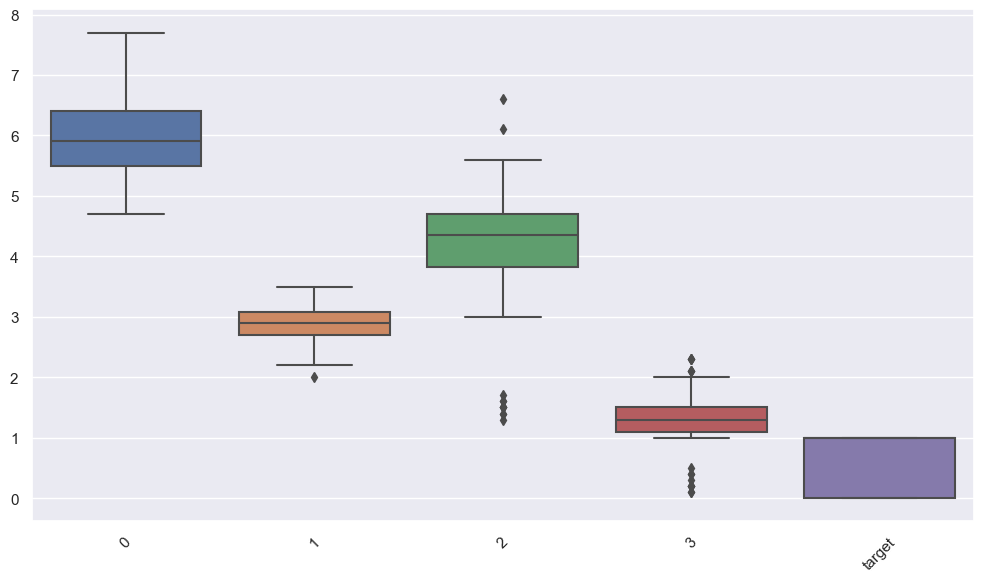

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
box = sns.boxplot(data=dataset_0) 
box.set_xticklabels(box.get_xticklabels(), rotation= 45) 
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

In [9]:
outliers = Counter(dataset_0['target'])[0]
inliers = Counter(dataset_0['target'])[1]

contamination = outliers/inliers 
contamination

0.4

In [10]:
n_features = dataset_0.shape[1]     # number of features

X = dataset_0[dataset_0.columns[:-1]]
y = dataset_0['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3
39,5.1,3.4,1.5,0.2
75,6.6,3.0,4.4,1.4
60,5.0,2.0,3.5,1.0
95,5.7,3.0,4.2,1.2
84,5.4,3.0,4.5,1.5


## PCA

In [243]:
#implementation PCA
pca = PCA_PYOD(n_components=2, contamination=contamination) 
pca.fit(X_train)


PCA(contamination=0.4, copy=True, iterated_power='auto', n_components=2,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [244]:
# PCA
# get the prediction labels and outlier scores of the training data
y_train_pred_pca = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores_pca = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data

# get the prediction labels and outlier scores of the test data
y_test_scores_pca = pca.decision_function(X_test)
y_test_pred_pca = pca.predict(X_test)


In [245]:
pca.get_params()

{'contamination': 0.4,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [246]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([2.81301326, 1.01586952]), array([0.68890121, 0.24878437])]

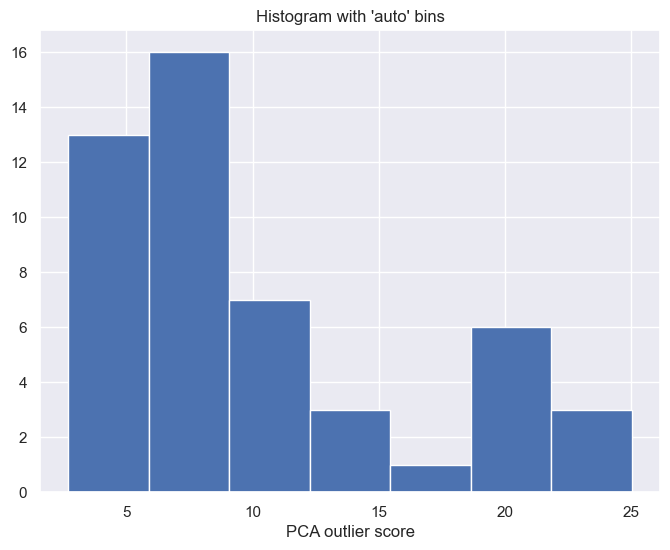

In [247]:
# get the prediction on the test data
y_test_pred_pca = pca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_pca = pca.decision_function(X_test)  # outlier scores

plt.hist(y_train_scores_pca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

## Kernel PCA

In [248]:
# KPCA
kpca = KPCA_PYOD(n_components=2, kernel='rbf', gamma=0.15, contamination=contamination)
kpca.fit(X_train)

KPCA(alpha=None, coef0=None, contamination=0.4, copy_X=None, degree=None,
   eigen_solver=None, gamma=None, kernel=None, kernel_params=None,
   max_iter=None, n_components=2, n_jobs=None, n_selected_components=None,
   random_state=RandomState(MT19937) at 0x2352F614740,
   remove_zero_eig=None, sampling=False, subset_size=20, tol=None)

In [249]:
# KPCA
# get the prediction labels and outlier scores of the training data
y_train_pred_kpca = kpca.labels_
y_train_scores_kpca = kpca.decision_scores_

# get the prediction labels and outlier scores of the test data
y_test_scores_kpca = kpca.decision_function(X_test)
y_test_pred_kpca = kpca.predict(X_test)

In [250]:
kpca.get_params()

{'alpha': None,
 'coef0': None,
 'contamination': 0.4,
 'copy_X': None,
 'degree': None,
 'eigen_solver': None,
 'gamma': None,
 'kernel': None,
 'kernel_params': None,
 'max_iter': None,
 'n_components': 2,
 'n_jobs': None,
 'n_selected_components': None,
 'random_state': RandomState(MT19937) at 0x2352F614740,
 'remove_zero_eig': None,
 'sampling': False,
 'subset_size': 20,
 'tol': None}

In [251]:
# get the prediction on the test data
y_test_pred_kpca = kpca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores_kpca = kpca.decision_function(X_test)  # outlier scores

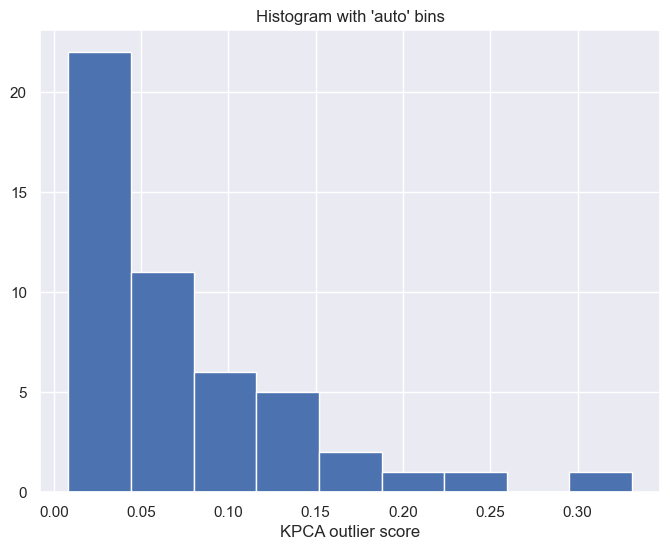

In [252]:
plt.hist(y_train_scores_kpca, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KPCA outlier score')
plt.show()

### Test other Kernels

In [ ]:
# Define a list of kernel functions and parameters to try
"""kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]"""

In [ ]:
"""# Perform kernelPCA
# Initialize a subplot grid to plot the results
fig, axs = plt.subplots(len(kernels), len(gammas), figsize=(15, 15), constrained_layout=True)

# Loop over the kernels and gammas and perform KPCA
for i, kernel in enumerate(kernels):
    for j, gamma in enumerate(gammas):
        # Initialize the KPCA transformer and fit the data
        kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma)
        X_kpca = kpca.fit_transform(X_train)

        # Plot the results
        axs[i, j].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_train, cmap='viridis', alpha=0.8)
        axs[i, j].set_title(f'{kernel} kernel, gamma={gamma}')

plt.show()"""

## Summary PCA and Kernel PCA

In [ ]:
threshold_pca = pca.threshold_
threshold_kpca = kpca.threshold_

print("The threshold of the PCA method for the defined comtanimation rate:" , threshold_pca)
print("The threshold of the KPCA method for the defined comtanimation rate:" , threshold_kpca)

In [ ]:
def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores_pca, threshold_pca)

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores_kpca, threshold_kpca)

In [ ]:
Actual_pred_pca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_pca})
Actual_pred_pca['Pred'] = np.where(Actual_pred_pca['Anomaly_Score']< threshold_pca,0,1)
pd.crosstab(Actual_pred_pca['Actual'],Actual_pred_pca['Pred'])

In [ ]:
Actual_pred_kpca = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores_kpca})
Actual_pred_kpca['Pred'] = np.where(Actual_pred_kpca['Anomaly_Score']< threshold_kpca,0,1)
pd.crosstab(Actual_pred_kpca['Actual'],Actual_pred_kpca['Pred'])

In [ ]:
# fit PCA on training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# fit KernelPCA on training data
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)
X_train_kpca = kpca.fit_transform(X_train)

# create a scatter plot of the projected data
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Kernel Principal Component 1')
plt.ylabel('Kernel Principal Component 2')
plt.show()

## SVM

In [10]:
dataset_0

,0,1,2,3,target
2,4.7,3.2,1.3,0.2,False
9,4.9,3.1,1.5,0.1,False
12,4.8,3.0,1.4,0.1,False
23,5.1,3.3,1.7,0.5,False
26,5.0,3.4,1.6,0.4,False
...,...,...,...,...,...
128,6.4,2.8,5.6,2.1,False
135,7.7,3.0,6.1,2.3,False
139,6.9,3.1,5.4,2.1,False
145,6.7,3.0,5.2,2.3,False


In [11]:
X = dataset_0[dataset_0.columns[:-1]]
y = dataset_0['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3
27,5.2,3.5,1.5,0.2
75,6.6,3.0,4.4,1.4
60,5.0,2.0,3.5,1.0
95,5.7,3.0,4.2,1.2
84,5.4,3.0,4.5,1.5


In [12]:
y_test

65      True
115    False
105    False
61      True
82      True
91      True
30     False
52      True
56      True
64      True
76      True
93      True
74      True
51      True
71      True
26     False
70      True
86      True
77      True
31     False
123    False
Name: target, dtype: bool

### rbf kernal

In [13]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.3, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [14]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)

In [15]:
prediction

array([ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
        1,  1, -1,  1], dtype=int64)

In [16]:
prediction = [False if i==-1 else True for i in prediction]

In [18]:
# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.80      0.67      0.73         6
        True       0.88      0.93      0.90        15

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21



In [19]:
print("The accuracy score predicted is {}".format(accuracy_score(y_test, prediction)))

The accuracy score predicted is 0.8571428571428571


In [20]:
print("The f1 score predicted is {}".format(f1_score(y_test, prediction)))

The f1 score predicted is 0.9032258064516129


In [21]:
ds1_f1 = []

In [22]:
ds1_f1.append(f1_score(y_test, prediction))

### linear kernal

In [23]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'linear', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]

print("The f1 score predicted is {}".format(f1_score(y_test, prediction)))

The f1 score predicted is 0.8484848484848485


In [24]:
ds1_f1.append(f1_score(y_test, prediction))

### Polynomial kernal

In [25]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'poly', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]

print("The f1 score predicted is {}".format(f1_score(y_test, prediction)))

The f1 score predicted is 0.8484848484848485


In [26]:
ds1_f1.append(f1_score(y_test, prediction))

### Sigmoid kernal

In [27]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.2, kernel = 'sigmoid', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]

print("The f1 score predicted is {}".format(f1_score(y_test, prediction)))

The f1 score predicted is 0.0


In [28]:
ds1_f1.append(f1_score(y_test, prediction))

In [29]:
ds1_f1

[0.9032258064516129, 0.8484848484848485, 0.8484848484848485, 0.0]

In [30]:


df_test = pd.DataFrame(X_test)

In [31]:
df_test = pd.DataFrame(X_test, columns=['0', '1','2','3'])

In [32]:
kernels = ['rbf','linear','poly','sigmoid']

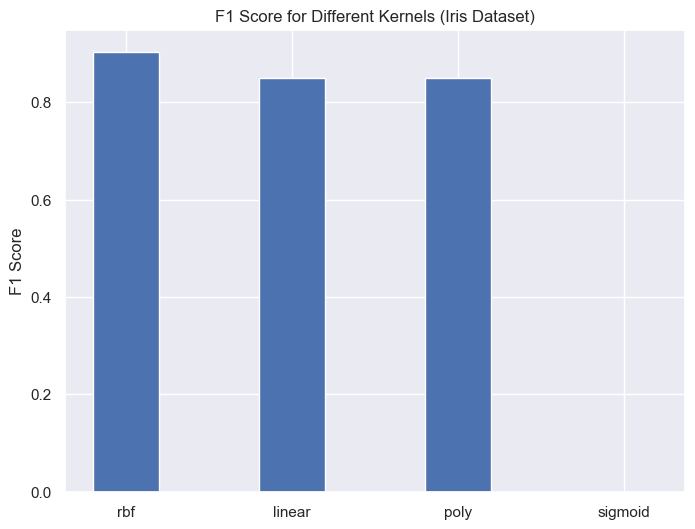

In [33]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Show the plot
plt.show()


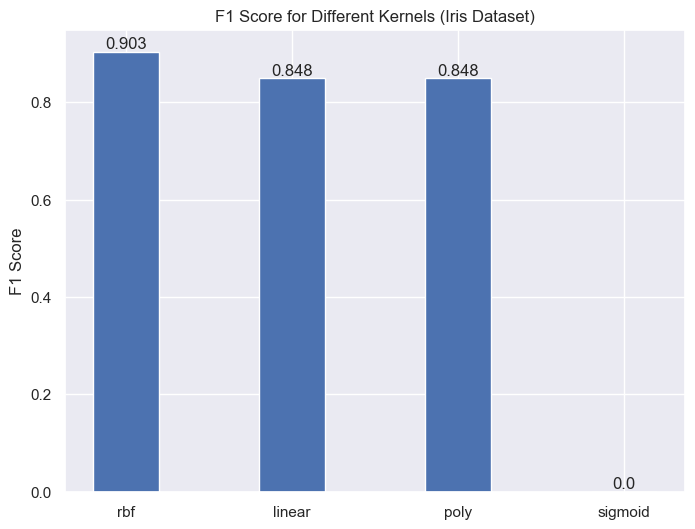

In [34]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()


##### 